# Post-processing

In [29]:
import json
import pandas as pd

sats = []

with open('data/spotGEO/train_anno.json') as f:
    for ann in json.load(f):
        for i, coords in enumerate(ann['object_coords']):
            sats.append({
                'sequence': ann['sequence_id'],
                'frame': ann['frame'],
                'satellite': i + 1,
                'r': int(coords[1] + .5),
                'c': int(coords[0] + .5),
            })
    
sats = pd.DataFrame(sats)
sats = sats.set_index(['sequence', 'frame', 'satellite'])
sats.head()

r    c
sequence frame satellite          
1        1     1          237  502
               2          222  490
               3          129  141
         2     1          214  530
               2          199  518

In [267]:
import pandas as pd

oof = pd.read_pickle('data/oof.pkl')
sightings = oof[oof.eq(True)].sort_index().reset_index(['r', 'c'])[['r', 'c']]
sightings.head()

r    c
sequence frame          
1        1      221  490
         1      237  501
         2      199  517
         2      214  529
         3       86  195

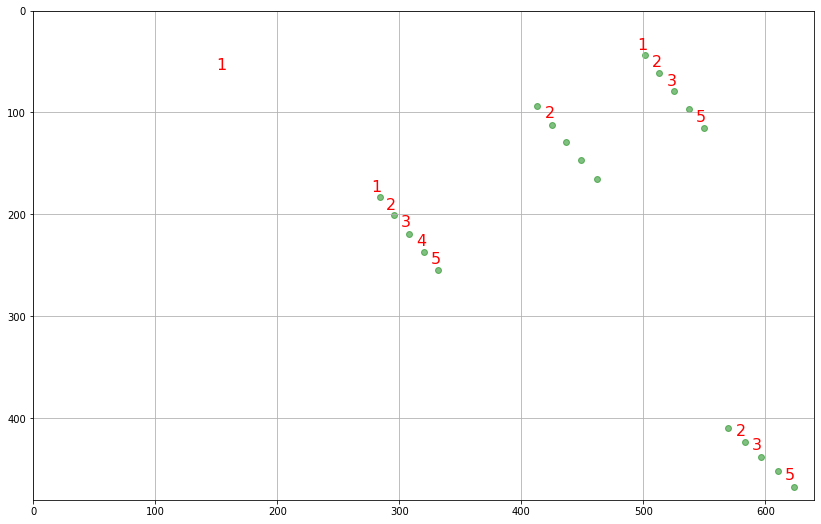

In [570]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 9))

sequence = 85

ax.set_xlim(0, 640)
ax.set_ylim(480, 0)
ax.grid()

try:
    for frame, (r, c) in sightings.loc[sequence].iterrows():
        ax.text(c - 6, r - 6, frame, color='red', fontsize=16)
except KeyError:
    pass
  
try:
    for (frame, _), (r, c) in sats.loc[sequence].iterrows():
        ax.scatter(c, r, color='green', alpha=.5)
except KeyError:
    pass

In [571]:
from scipy import stats

class Trajectory:
    
    def __init__(self, frames, r, c):
        self.r_linreg = stats.linregress(x=frames, y=r)
        self.c_linreg = stats.linregress(x=frames, y=c)
        
    @property
    def good_fit(self):
        return abs(self.r_linreg.rvalue) > .999 and abs(self.c_linreg.rvalue) > .999
    
    def get_path(self):
        return [
            [
                self.r_linreg.slope * frame + self.r_linreg.intercept,
                self.c_linreg.slope * frame + self.c_linreg.intercept,
            ]
            for frame in range(1, 6)
        ]

Let's look at the average distance between positions of a single satellite.

In [ ]:
counts = sats.groupby(['sequence']).size()
single = counts[counts.eq(5)]
sats.loc[single.index].groupby('sequence').apply(lambda g: g.diff()['r'].abs() + g.diff()['c'].abs()).agg(['mean', 'std', 'min', 'max'])

In [585]:
def find_trajectory(frames):

    # We first consider all the trajectories that are formed with 3, 4, or 5 points from different
    # frame. We fit a line to every possible point combination. We stop if we find a "good" line.
    # We can then remove the involved points and call this function once again.
    for k in range(5, 2, -1):
        for frame_combo in itertools.combinations(range(5), k):
            for coord_combo in itertools.product(*[range(len(frames[f])) for f in frame_combo]):
                r = [frames[i][j][0] for i, j in zip(frame_combo, coord_combo)]
                c = [frames[i][j][1] for i, j in zip(frame_combo, coord_combo)]
                traj = Trajectory(frames=[f + 1 for f in frame_combo], r=r, c=c)
                if traj.good_fit:
                    return frame_combo, coord_combo, traj
        
    # Now we look at pairs of points in adjacent frames. We assume that two point from different
    # frames form a trajectory if their distance looks likely.
    for i1 in range(4):
        for i2 in range(i1 + 1, min(i1 + 3, 5)):
            for j1, j2 in itertools.product(range(len(frames[i1])), range(len(frames[i2]))):
                r1, c1 = frames[i1][j1]
                r2, c2 = frames[i2][j2]
                dist = abs(r1 - r2) + abs(c1 - c2)
                if 18 * (i2 - i1) <= dist <= 70 * (i2 - i1):
                    traj = Trajectory(frames=[i1 + 1, i2 + 1], r=[r1, r2], c=[c1, c2])
                    return (i1, i2), (j1, j2), traj
        
    return None

def expand_predictions(predictions):

    trajectories = []
              
    frames = [[] for _ in range(5)]
    for frame, (r, c) in predictions.iterrows():
        frames[frame - 1].append([r, c])

    while frames:

        result = find_trajectory(frames)
        if result is None:
            break

        frame_combo, coord_combo, traj = result
        trajectories.append(traj)
        for i, j in zip(frame_combo, coord_combo):
            del frames[i][j]
            
    expansion = pd.concat([
        pd.DataFrame(traj.get_path(), columns=['r', 'c'])
        for traj in trajectories
    ])
    expansion.index.name = 'frame'
    expansion.index += 1
    
    return expansion

predictions = sightings.loc[sequence]
expansion = expand_predictions(predictions)
expansion

,r,c
frame,,
1,183.000000,282.800000
2,200.700000,295.100000
3,218.400000,307.400000
4,236.100000,319.700000
5,253.800000,332.000000
1,43.600000,501.000000
2,61.400000,513.000000
3,79.200000,525.000000
4,97.000000,537.000000


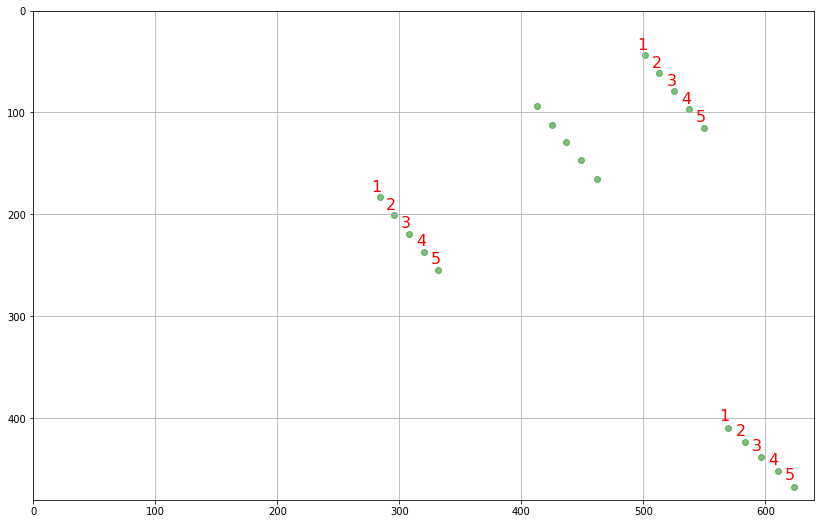

In [586]:
fig, ax = plt.subplots(figsize=(14, 9))

ax.set_xlim(0, 640)
ax.set_ylim(480, 0)
ax.grid()

for (frame, _), (r, c) in sats.loc[sequence].iterrows():
    ax.scatter(c, r, color='green', alpha=.5)
    
for frame, (r, c) in expansion.iterrows():
    ax.text(c - 6, r - 6, frame, color='red', fontsize=16)